In [1]:
import cv2
import numpy as np

from nms import get_boxes

from models import ModelResNetSep2
import net_utils

from ocr_utils import ocr_image
from data_gen import draw_box_points
import torch

In [2]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

In [3]:
f = open('codec.txt', 'r', encoding='utf-8')
codec = f.readlines()[0]
f.close()

In [4]:
def resize_image(im, max_size = 1585152, scale_up=True):

    if scale_up:
        image_size = [im.shape[1] * 6 // 32 * 32, im.shape[0] * 6 // 32 * 32]
    else:
        image_size = [im.shape[1] // 32 * 32, im.shape[0] // 32 * 32]
    while image_size[0] * image_size[1] > max_size:
        image_size[0] /= 1.2
        image_size[1] /= 1.2
        image_size[0] = int(image_size[0] // 32) * 32
        image_size[1] = int(image_size[1] // 32) * 32

    resize_h = int(image_size[1])
    resize_w = int(image_size[0])

    scaled = cv2.resize(im, dsize=(resize_w, resize_h))
    return scaled, (resize_h, resize_w)

In [5]:
font2 = ImageFont.truetype("Arial-Unicode-Regular.ttf", 18)

In [6]:
net = ModelResNetSep2(attention=True)
net_utils.load_net("e2e-mlt.h5", net)
net = net.eval()

e2e-mlt.h5


In [7]:
im = cv2.imread("../data/ICDAR/end-to-end/ch2_training_images/img_2.jpg")

In [8]:
im_resized, (ratio_h, ratio_w) = resize_image(im, scale_up=False)
images = np.asarray([im_resized], dtype=np.float)
images /= 128
images -= 1
im_data = net_utils.np_to_variable(images, is_cuda=False).permute(0, 3, 1, 2)
seg_pred, rboxs, angle_pred, features = net(im_data)

In [9]:
from IPython.display import Image as imgd
from matplotlib import pyplot as plt

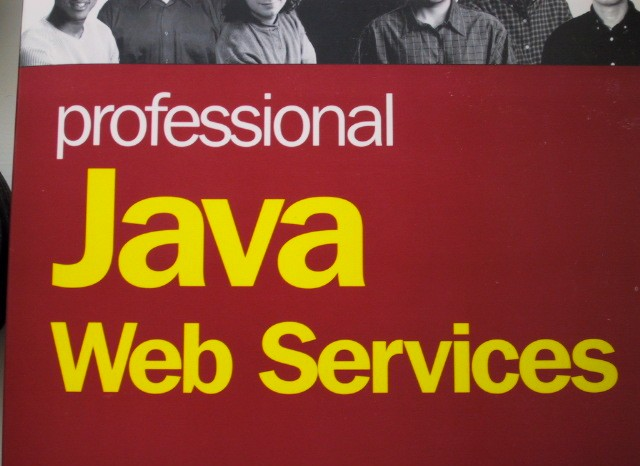

In [10]:
imgd(filename="../data/ICDAR/end-to-end/ch2_training_images/img_2.jpg")

In [11]:
rbox = rboxs[0].data.cpu()[0].numpy()
rbox = rbox.swapaxes(0, 1)
rbox = rbox.swapaxes(1, 2)

angle_pred = angle_pred[0].data.cpu()[0].numpy()

segm = seg_pred[0].data.cpu()[0].numpy()
segm = segm.squeeze(0)

draw2 = np.copy(im_resized)
boxes =  get_boxes(segm, rbox, angle_pred, False)

In [12]:
img = Image.fromarray(draw2)
draw = ImageDraw.Draw(img)

In [13]:
eps = 100.0

In [14]:
if len(boxes) > 10:
    boxes = boxes[0:10]

out_boxes = []
for box in boxes:
    # my
    probability = box[8]
    if (probability < eps):
        continue
    
    pts  = box[0:8]
    pts = pts.reshape(4, -1)

    det_text, conf, dec_s = ocr_image(net, codec, im_data, box)
    if len(det_text) == 0:
        continue

    width, height = draw.textsize(det_text, font=font2)
    center =  [box[0], box[1]]
    draw.text((center[0], center[1]), det_text, fill = (0,255,0),font=font2)
    out_boxes.append(box)
    print(det_text)

    im = np.array(img)

Services
professional
Java
Web


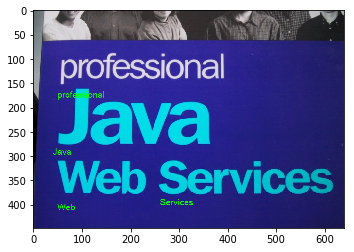

In [15]:
plt.imshow(im)
plt.show()

In [16]:
out_boxes

[array([ 261.2148,  381.0536,  262.1008,  306.3096,  613.7385,  309.105 ,
         611.1295,  392.7637, 1172.5046], dtype=float32),
 array([  50.2773,  160.3917,   49.4468,   72.2098,  392.0952,   66.6966,
         396.7283,  145.2672, 1065.236 ], dtype=float32),
 array([  41.9333,  277.007 ,   44.7002,  159.7203,  373.4899,  164.7885,
         374.0135,  279.1798, 1732.1259], dtype=float32),
 array([ 50.422 , 391.5088,  53.5161, 307.1966, 231.5939, 315.2685,
        230.6831, 395.3672, 599.4792], dtype=float32)]

In [17]:
for box in out_boxes:
    pts  = box[0:8]
    pts = pts.reshape(4, -1)
    draw_box_points(im, pts, color=(0, 255, 0), thickness=1)

#     cv2.imshow('img', im)
#     cv2.waitKey(10)

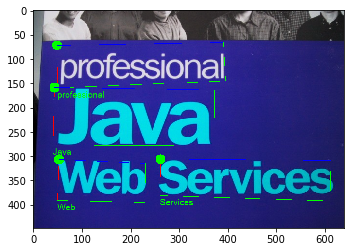

In [20]:
plt.imshow(im)
plt.show()